<h1>Pre-Processing</h1>
<ul>
	<li>Equalize histogram</li>
	<li>Resize</li>
	<li>Save Data</li>
</ul>

In [1]:
import numpy as np

def histogram_equalization(img):
	flat = img.flatten()
	hist = [0] * 256
	for pixel in flat:
		hist[pixel] += 1

	cdf = [0] * 256
	cdf[0] = hist[0]
	for i in range(1, 256):
		cdf[i] = cdf[i-1] + hist[i]
	cdf_min = min([x for x in cdf if x > 0])
	total = flat.size

	lut = [0] * 256
	for i in range(256):
		lut[i] = round((cdf[i] - cdf_min) / (total - cdf_min) * 255)
		lut[i] = max(0, min(255, lut[i]))

	equalized = [lut[p] for p in flat]
	return np.array(equalized, dtype=np.uint8).reshape(img.shape)

In [2]:
def resize_image(img, new_width, new_height):
	h, w = img.shape[:2]
	if len(img.shape) == 3:
		c = img.shape[2]
		resized = np.zeros((new_height, new_width, c), dtype=img.dtype)
	else:
		resized = np.zeros((new_height, new_width), dtype=img.dtype)

	for i in range(new_height):
		for j in range(new_width):
			src_x = int(j * w / new_width)
			src_y = int(i * h / new_height)
			src_x = min(src_x, w - 1)
			src_y = min(src_y, h - 1)
			resized[i, j] = img[src_y, src_x]
	return resized

In [3]:
def bgr_to_rgb(img):
	return img[..., ::-1]

In [ ]:
import cv2
import mediapipe as mp

mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

face_detection = mp_face_detection.FaceDetection(
	model_selection=1,
	min_detection_confidence=0.5
)

image = cv2.imread('./Data/1 (1188).jpg')
image_rgb = bgr_to_rgb(image)

results = face_detection.process(image_rgb)

if results.detections:
	for i, detection in enumerate(results.detections):
		bboxC = detection.location_data.relative_bounding_box
		ih, iw, _ = image.shape

		x = int(bboxC.xmin * iw)
		y = int(bboxC.ymin * ih)
		w = int(bboxC.width * iw)
		h = int(bboxC.height * ih)

		face_img = image[y:y+h, x:x+w]
		face_img = resize_image(histogram_equalization(face_img), 450, 450)
		cv2.imwrite(f'face_{i}.jpg', face_img)

# Feature extraction
<ul>
	<li>LBP</li>
	<li>HOG</li>
	<li>Face landmark</li>
</ul>

        ### Extract lbp - uniform

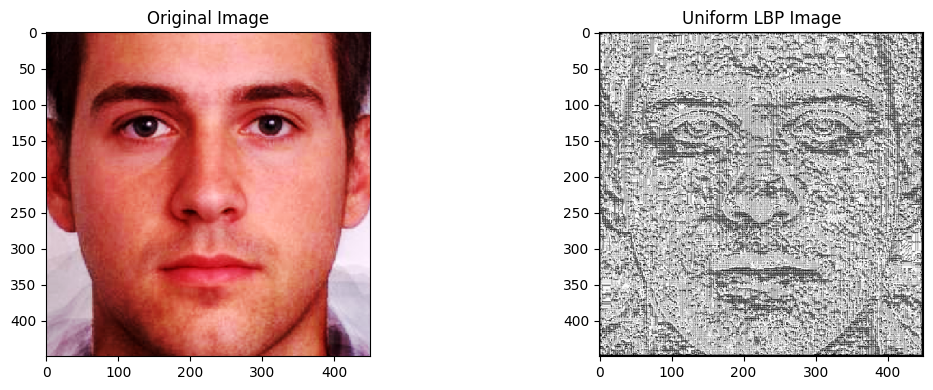

Uniform LBP feature vector shape: (59,)
Number of uniform patterns: 58


In [11]:

import matplotlib.pyplot as plt
def extract_uniform_lbp(image, radius=1, points=8):
	if len(image.shape) == 3:
		gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	else:
		gray = image
	
	height, width = gray.shape
	lbp_image = np.zeros((height, width), dtype=np.uint8)
	
	uniform_patterns = []
	for i in range(0, 2**points):
		bitstring = format(i, f'0{points}b')
		transitions = 0
		for j in range(points):
			transitions += (bitstring[j] != bitstring[(j+1) % points])
		
		if transitions <= 2:
			uniform_patterns.append(i)
	
	n_patterns = len(uniform_patterns)
	uniform_map = {pattern: idx for idx, pattern in enumerate(uniform_patterns)}
	
	for y in range(radius, height - radius):
		for x in range(radius, width - radius):
			center = gray[y, x]
			binary = 0
			
			for p in range(points):
				angle = 2 * np.pi * p / points
				x_p = int(round(x + radius * np.cos(angle)))
				y_p = int(round(y + radius * np.sin(angle)))
				
				if gray[y_p, x_p] >= center:
					binary |= (1 << p)
			
			if binary in uniform_map:
				lbp_image[y, x] = uniform_map[binary]
			else:
				lbp_image[y, x] = n_patterns
	
	hist, _ = np.histogram(lbp_image, bins=n_patterns+1, range=(0, n_patterns))
	
	hist = hist.astype("float") / hist.sum()
	
	return hist, lbp_image

uniform_hist, uniform_lbp = extract_uniform_lbp(face_img, radius=2, points=8)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.imshow(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.subplot(122)
plt.imshow(uniform_lbp, cmap='gray')
plt.title("Uniform LBP Image")
plt.tight_layout()
plt.show()

print(f"Uniform LBP feature vector shape: {uniform_hist.shape}")
print(f"Number of uniform patterns: {uniform_hist.shape[0] - 1}")

        ### Extract HOG

In [12]:
def bgr_to_gray(image):
	b = image[..., 0].astype(np.float32)
	g = image[..., 1].astype(np.float32)
	r = image[..., 2].astype(np.float32)
	gray = 0.114 * b + 0.587 * g + 0.299 * r
	return gray.astype(np.uint8)

In [13]:
def manual_sobel_x(image):
	if len(image.shape) > 2:
			raise ValueError("Đầu vào phải là ảnh grayscale")
	image = image.astype(np.float64)
	height, width = image.shape
	gradient_x = np.zeros((height, width), dtype=np.float64)
	for y in range(height):
			for x in range(1, width - 1):
					gradient_x[y, x] = image[y, x + 1] - image[y, x - 1]
	for y in range(height):
			gradient_x[y, 0] = image[y, 1] - image[y, 0]
	
	for y in range(height):
			gradient_x[y, width - 1] = image[y, width - 1] - image[y, width - 2]
	
	return gradient_x

def manual_sobel_y(image):
	if len(image.shape) > 2:
			raise ValueError("Đầu vào phải là ảnh grayscale")
	image = image.astype(np.float64)
	
	height, width = image.shape
	
	gradient_y = np.zeros((height, width), dtype=np.float64)

	for y in range(1, height - 1):
			for x in range(width):
					gradient_y[y, x] = image[y + 1, x] - image[y - 1, x]

	for x in range(width):
			gradient_y[0, x] = image[1, x] - image[0, x]
	
	for x in range(width):
			gradient_y[height - 1, x] = image[height - 1, x] - image[height - 2, x]
	
	return gradient_y

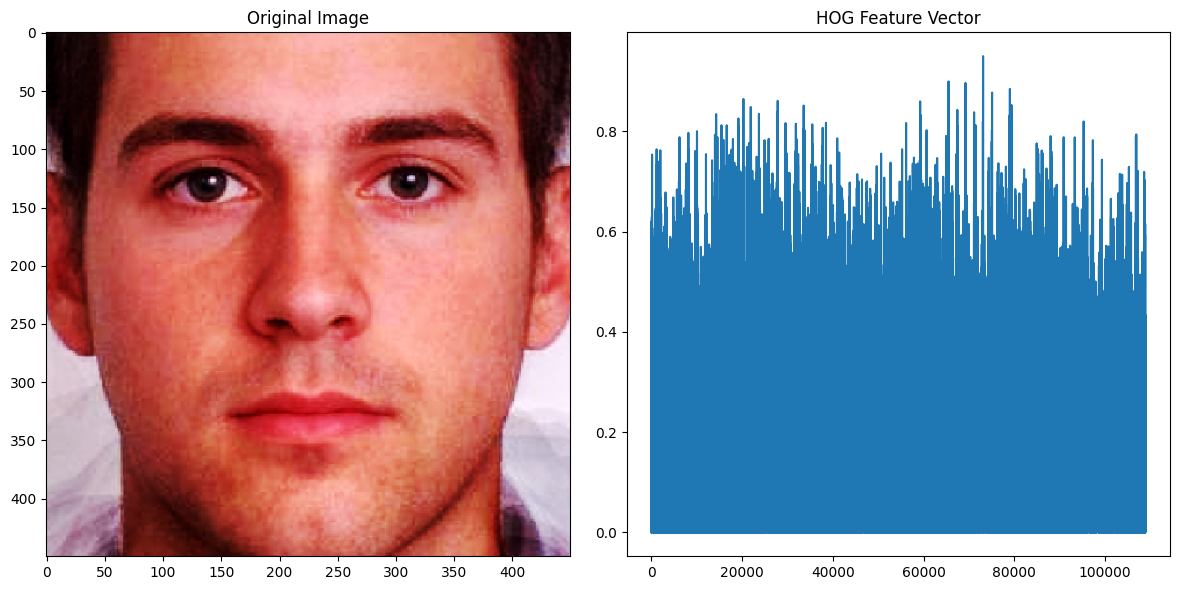

HOG feature vector shape: (108900,)


In [14]:
def extract_hog_features(image, cell_size=8, block_size=2, bins=9):
	if len(image.shape) == 3:
		gray = bgr_to_gray(image)
	else:
		gray = image.copy()
		
	height, width = gray.shape
	
	gx = manual_sobel_x(gray)
	gy = manual_sobel_y(gray)

	# gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=1)
	# gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=1)

	magnitude = np.sqrt(gx**2 + gy**2)
	orientation = np.arctan2(gy, gx) * (180 / np.pi) % 180
	
	n_cells_y = height // cell_size
	n_cells_x = width // cell_size
	
	hog_cells = np.zeros((n_cells_y, n_cells_x, bins))
	
	for y in range(n_cells_y):
		for x in range(n_cells_x):
			cell_magnitude = magnitude[y*cell_size:(y+1)*cell_size, 
										x*cell_size:(x+1)*cell_size]
			cell_orientation = orientation[y*cell_size:(y+1)*cell_size, 
											x*cell_size:(x+1)*cell_size]
			
			for i in range(cell_size):
				for j in range(cell_size):
					if y*cell_size+i < height and x*cell_size+j < width:
						grad_mag = cell_magnitude[i, j]
						grad_ang = cell_orientation[i, j]
						
						bin_index = int(grad_ang / (180.0 / bins)) % bins
						hog_cells[y, x, bin_index] += grad_mag
	
	n_blocks_y = n_cells_y - block_size + 1
	n_blocks_x = n_cells_x - block_size + 1
	normalized_blocks = np.zeros((n_blocks_y, n_blocks_x, block_size * block_size * bins))
	
	for y in range(n_blocks_y):
		for x in range(n_blocks_x):
			block = hog_cells[y:y+block_size, x:x+block_size, :].flatten()
			block_norm = np.sqrt(np.sum(block**2) + 1e-10)
			if block_norm > 0:
				block = block / block_norm
			normalized_blocks[y, x, :] = block
	
	hog_features = normalized_blocks.flatten()
	
	plt.figure(figsize=(12, 6))
	plt.subplot(121)
	plt.imshow(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))
	plt.title("Original Image")
	plt.subplot(122)
	plt.plot(hog_features)
	plt.title("HOG Feature Vector")
	plt.tight_layout()
	plt.show()
	
	print(f"HOG feature vector shape: {hog_features.shape}")
	
	return hog_features

cell_size = 8
block_size = 2
bins = 9
hog_features = extract_hog_features(face_img, cell_size=cell_size, block_size=block_size, bins=bins)

        ### Extract face landmarks

In [31]:
def extract_face_landmarks(image):
  mp_face_mesh = mp.solutions.face_mesh
  face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)
  
  rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  
  results = face_mesh.process(rgb_image)
  
  if not results.multi_face_landmarks:
    return np.zeros(10)  
  
  landmarks = results.multi_face_landmarks[0].landmark
  
  h, w = image.shape[:2]
  landmarks_array = np.array([[lm.x * w, lm.y * h] for lm in landmarks])
  
  left_eye = landmarks_array[33]
  right_eye = landmarks_array[263]
  nose_tip = landmarks_array[1]
  mouth_left = landmarks_array[61]
  mouth_right = landmarks_array[291]
  
  chin = landmarks_array[152]       
  forehead = landmarks_array[10]    
  left_eyebrow = landmarks_array[107] 
  right_eyebrow = landmarks_array[336] 
  
  ratios = []
  
  eyes_distance = np.linalg.norm(left_eye - right_eye)
  face_width = np.linalg.norm(landmarks_array[234] - landmarks_array[454])
  ratios.append(eyes_distance / face_width)
  
  left_eye_nose_distance = np.linalg.norm(left_eye - nose_tip)
  face_height = np.linalg.norm(forehead - chin)
  ratios.append(left_eye_nose_distance / face_height)
  
  nose_mouth_distance = (np.linalg.norm(nose_tip - mouth_left) + np.linalg.norm(nose_tip - mouth_right)) / 2
  ratios.append(nose_mouth_distance / face_height)
  
  mouth_width = np.linalg.norm(mouth_left - mouth_right)
  ratios.append(mouth_width / face_width)
  
  right_eye_mouth_distance = np.linalg.norm(right_eye - mouth_right)
  ratios.append(right_eye_mouth_distance / face_height)

  forehead_nose_distance = np.linalg.norm(forehead - nose_tip)
  ratios.append(forehead_nose_distance / face_height)
  
  nose_chin_distance = np.linalg.norm(nose_tip - chin)
  ratios.append(nose_chin_distance / face_height)
  
  eyebrows_distance = np.linalg.norm(left_eyebrow - right_eyebrow)
  ratios.append(eyebrows_distance / face_width)
  
  ratios.append(face_height / face_width)
  
  left_eye_to_eyebrow = np.linalg.norm(left_eye - left_eyebrow)
  right_eye_to_eyebrow = np.linalg.norm(right_eye - right_eyebrow)
  eye_eyebrow_avg_distance = (left_eye_to_eyebrow + right_eye_to_eyebrow) / 2
  ratios.append(eye_eyebrow_avg_distance / face_height)
  
  return np.array(ratios)

In [32]:
test = extract_face_landmarks(face_img)